#**Практическое задание №1**

Установка необходимых пакетов:

In [1]:
!pip install -q tqdm
!pip install --upgrade --no-cache-dir gdown

Монтирование Вашего Google Drive к текущему окружению:

In [26]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Константы, которые пригодятся в коде далее, и ссылки (gdrive идентификаторы) на предоставляемые наборы данных:

In [25]:
EVALUATE_ONLY = True
TEST_ON_LARGE_DATASET = True
TISSUE_CLASSES = ('ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM')
DATASETS_LINKS = {
    'train': '1XtQzVQ5XbrfxpLHJuL0XBGJ5U7CS-cLi',
    'train_small': '1qd45xXfDwdZjktLFwQb-et-mAaFeCzOR',
    'train_tiny': '1I-2ZOuXLd4QwhZQQltp817Kn3J0Xgbui',
    'test': '1RfPou3pFKpuHDJZ-D9XDFzgvwpUBFlDr',
    'test_small': '1wbRsog0n7uGlHIPGLhyN-PMeT2kdQ2lI',
    'test_tiny': '1viiB0s041CNsAK4itvX8PnYthJ-MDnQc'
}

Импорт необходимых зависимостей:

In [22]:
from pathlib import Path
import os
import numpy as np
from typing import List
from tqdm.notebook import tqdm
from time import sleep
from PIL import Image
import IPython.display
from sklearn.metrics import balanced_accuracy_score
import gdown
import tensorflow as tf
import seaborn as sns
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

---
### Класс Dataset

Предназначен для работы с наборами данных, обеспечивает чтение изображений и соответствующих меток, а также формирование пакетов (батчей).

In [27]:
class Dataset:

    def __init__(self, name):
        self.name = name
        self.is_loaded = False
        url = f"https://drive.google.com/uc?export=download&confirm=pbef&id={DATASETS_LINKS[name]}"
        output = f'{name}.npz'
        gdown.download(url, output, quiet=False)
        print(f'Loading dataset {self.name} from npz.')
        np_obj = np.load(f'{name}.npz')
        self.images = np_obj['data']
        self.labels = np_obj['labels']
        self.n_files = self.images.shape[0]
        self.is_loaded = True
        print(f'Done. Dataset {name} consists of {self.n_files} images.')

    def image(self, i):
        # read i-th image in dataset and return it as numpy array
        if self.is_loaded:
            return self.images[i, :, :, :]

    def images_seq(self, n=None):
        # sequential access to images inside dataset (is needed for testing)
        for i in range(self.n_files if not n else n):
            yield self.image(i)

    def random_image_with_label(self):
        # get random image with label from dataset
        i = np.random.randint(self.n_files)
        return self.image(i), self.labels[i]

    def random_batch_with_labels(self, n):
        # create random batch of images with labels (is needed for training)
        indices = np.random.choice(self.n_files, n)
        imgs = []
        for i in indices:
            img = self.image(i)
            imgs.append(self.image(i))
        logits = np.array([self.labels[i] for i in indices])
        return np.stack(imgs), logits

    def image_with_label(self, i: int):
        # return i-th image with label from dataset
        return self.image(i), self.labels[i]

### Пример использвания класса Dataset
Загрузим обучающий набор данных, получим произвольное изображение с меткой. После чего визуализируем изображение, выведем метку. В будущем, этот кусок кода можно закомментировать или убрать.

Загрузка набора данных train_tiny из файла /content/drive/MyDrive/train_tiny.npz.
Готово. Набор данных train_tiny содержит 900 изображений.

Got numpy array of shape (224, 224, 3), and label with code 1.
Label code corresponds to BACK class.


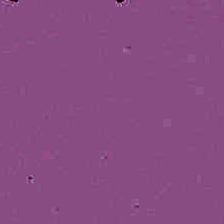

In [ ]:
d_train_tiny = Dataset('train_tiny')

img, lbl = d_train_tiny.random_image_with_label()
print()
print(f'Got numpy array of shape {img.shape}, and label with code {lbl}.')
print(f'Label code corresponds to {TISSUE_CLASSES[lbl]} class.')

pil_img = Image.fromarray(img)
IPython.display.display(pil_img)

---
### Класс Metrics

Реализует метрики точности, используемые для оценивания модели:
1. точность,
2. сбалансированную точность.

In [18]:
class Metrics:

    @staticmethod
    def accuracy(gt: List[int], pred: List[int]):
        assert len(gt) == len(pred), 'gt and prediction should be of equal length'
        return sum(int(i[0] == i[1]) for i in zip(gt, pred)) / len(gt)

    @staticmethod
    def accuracy_balanced(gt: List[int], pred: List[int]):
        return balanced_accuracy_score(gt, pred)

    @staticmethod
    def print_all(gt: List[int], pred: List[int], info: str):
        print(f'metrics for {info}:')
        print('\t accuracy {:.4f}:'.format(Metrics.accuracy(gt, pred)))
        print('\t balanced accuracy {:.4f}:'.format(Metrics.accuracy_balanced(gt, pred)))

---
### Класс Model

Класс, хранящий в себе всю информацию о модели.


Реализовано:
1. **Валидация модели на части обучающей выборки**:
В методе `train` происходит разделение данных на обучающую и валидационную выборки с использованием `train_test_split`.
Валидационные данные передаются в `validation_data` во время вызова `self.model.fit`.
2. **Автоматическое сохранение модели при обучении**:
Используется `tf.keras.callbacks.ModelCheckpoint` для сохранения лучшей модели во время обучения `(save_best_only=True)`.

3. **Загрузка модели с какой-то конкретной итерации обучения**:
Метод `load` позволяет загрузить модель из указанного файла, что может использоваться для продолжения обучения.

4. **Вывод различных показателей в процессе обучения**:
Метод `fit` автоматически выводит значения функции потерь и точности на каждой эпохе.

5. **Построение матрицы ошибок, оценивание чувствительности и специфичности модели**:
В методе `test_on_dataset` строится матрица ошибок `(confusion_matrix)`, а также выводятся метрики `precision`, `recall`, `F1-score` с использованием `classification_report`.

6. **Использование аугментации данных**:
В методе `prepare_dataset` включена опция `augment`, которая вызывает метод `augment_image` для выполнения аугментации (перевороты, изменение яркости и контрастности).

In [19]:
class Model:
    def __init__(self):
        input_shape = (224, 224, 3)

        self.model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=input_shape),
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D((2, 2)),

            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D((2, 2)),

            tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D((2, 2)),

            tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.GlobalAveragePooling2D(),

            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(9, activation='softmax')  # output layer for 9 klasses
        ])

        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        print("Model is ready")

    def save(self, name: str):
        model_save_path = f'/content/drive/MyDrive/{name}.keras'
        self.model.save(model_save_path)
        print(f"Model saved in {model_save_path}")

    def load(self, name: str): #LBL3
        model_load_path = f'/content/drive/MyDrive/{name}.keras'
        if not os.path.exists(model_load_path):
          gdown.download(url="https://drive.google.com/uc?id=1_osFE42zSXnIGh6v9GqzSlS03JOPlgEL", output=model_load_path, quiet=False)
        self.model = tf.keras.models.load_model(model_load_path)
        print(f"Model downloaded {model_load_path}.")



    def train(self, dataset: Dataset):
        print(f'Learning begins')
        images = dataset.images
        labels = dataset.labels

        unique_labels, counts = np.unique(labels, return_counts=True) # checking distribution
        print("Distribution the training data set:")
        for label, count in zip(unique_labels, counts):
            print(f"Class {label}: {count} images")

        class_weights_array = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=unique_labels,
            y=labels
        )
        class_weights = dict(enumerate(class_weights_array))

        #LBL1
        # dividing into train and val samples
        train_images, val_images, train_labels, val_labels = train_test_split(
            images, labels, test_size=0.2, stratify=labels, random_state=42
        )

        train_ds = self.prepare_dataset(train_images, train_labels, batch_size=16, augment=True)
        val_ds = self.prepare_dataset(val_images, val_labels, batch_size=16)

        callbacks = [
            tf.keras.callbacks.ModelCheckpoint(
                filepath='/content/drive/MyDrive/best_model.keras',
                save_best_only=True #LBL2
            ),
            tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
            tf.keras.callbacks.TensorBoard(log_dir='./logs')
        ]

        self.model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=20,
            callbacks=callbacks,
            class_weight=class_weights
        ) #LBL4

        print(f'Train ended')

    def prepare_dataset(self, images, labels, batch_size, augment=False, shuffle=False):
        dataset = tf.data.Dataset.from_tensor_slices((images, labels))

        def preprocess(img, label):
            img = tf.image.convert_image_dtype(img, tf.float32)
            img = tf.image.resize(img, [224, 224])
            if augment:
                img = self.augment_image(img)
            return img, label
        if shuffle:
          dataset = dataset.shuffle(buffer_size=1000)

        dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.batch(batch_size)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)

        return dataset

    def augment_image(self, img): #LBL6
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        img = tf.image.random_brightness(img, max_delta=0.2)
        img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
        return img

    def test_on_dataset(self, dataset: Dataset, limit=None):
        images = dataset.images
        labels = dataset.labels

        if limit:
            n_samples = int(len(images) * limit)
            images = images[:n_samples]
            labels = labels[:n_samples]

        test_ds = self.prepare_dataset(images, labels, batch_size=32)

        predictions = self.model.predict(test_ds)
        predicted_classes = np.argmax(predictions, axis=1)

        print("report:")
        print(classification_report(labels, predicted_classes, target_names=TISSUE_CLASSES))

        cm = confusion_matrix(labels, predicted_classes) #LBL5
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=TISSUE_CLASSES, yticklabels=TISSUE_CLASSES)
        plt.xlabel('predicted')
        plt.ylabel('true')
        plt.title('confusion matrix')
        plt.show()

        return predicted_classes

    def test_on_image(self, img: np.ndarray):
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = tf.image.resize(img, [224, 224])
        img = tf.expand_dims(img, axis=0)

        predictions = self.model.predict(img)
        predicted_class = np.argmax(predictions, axis=1)[0]
        return predicted_class


---
### Классификация изображений

Используя введенные выше классы можем перейти уже непосредственно к обучению модели классификации изображений. Пример общего пайплайна решения задачи приведен ниже. Вы можете его расширять и улучшать. В данном примере используются наборы данных 'train_small' и 'test_small'.

In [28]:
d_train = Dataset('train')
d_test = Dataset('test')

model = Model()

if not EVALUATE_ONLY:
    model.train(d_train)
    model.save('best_model')
else:
    model.load('best_model')

Ready, dataset train contains 18000 images.
Ready, dataset test contains 4500 images.
Model is ready


Downloading...
From: https://drive.google.com/uc?id=1_osFE42zSXnIGh6v9GqzSlS03JOPlgEL
To: /content/drive/MyDrive/best_model.keras
100%|██████████| 7.94M/7.94M [00:00<00:00, 46.2MB/s]


Model downloaded /content/drive/MyDrive/best_model.keras.


Пример тестирования модели на полном наборе данных:

141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step
report:
              precision    recall  f1-score   support

         ADI       1.00      0.97      0.99       500
        BACK       0.96      1.00      0.98       500
         DEB       0.97      0.93      0.95       500
         LYM       1.00      0.99      1.00       500
         MUC       0.96      0.97      0.97       500
         MUS       0.97      0.98      0.98       500
        NORM       0.97      0.96      0.97       500
         STR       0.90      0.97      0.93       500
         TUM       0.98      0.95      0.96       500

    accuracy                           0.97      4500
   macro avg       0.97      0.97      0.97      4500
weighted avg       0.97      0.97      0.97      4500



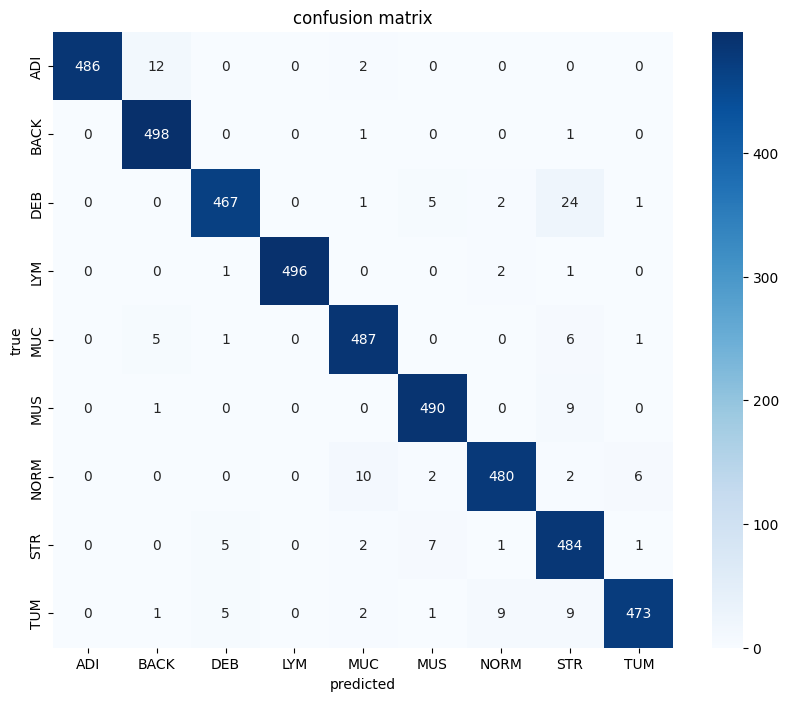

metrics for test:
	 accuracy 0.9691:
	 balanced accuracy 0.9691:
[0 0 0 ... 8 8 8]


In [29]:
# evaluating model on full test dataset (may take time)
if TEST_ON_LARGE_DATASET:
    pred_2 = model.test_on_dataset(d_test)
    Metrics.print_all(d_test.labels, pred_2, 'test')
    print(pred_2)

### Тестирование модели на других наборах данных

Ваша модель должна поддерживать тестирование на других наборах данных. Для удобства, Вам предоставляется набор данных test_tiny, который представляет собой малую часть (2% изображений) набора test. Ниже приведен фрагмент кода, который будет осуществлять тестирование для оценивания Вашей модели на дополнительных тестовых наборах данных.

<font color="red">
Прежде чем отсылать задание на проверку, убедитесь в работоспособности фрагмента кода ниже.
</font>

Model is ready
Model downloaded /content/drive/MyDrive/best_model.keras.
Ready, dataset test_small contains 1800 images.
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step
report:
              precision    recall  f1-score   support

         ADI       1.00      0.98      0.99       200
        BACK       1.00      0.98      0.99       200
         DEB       0.94      0.93      0.93       200
         LYM       0.99      0.99      0.99       200
         MUC       0.95      0.98      0.97       200
         MUS       0.90      0.97      0.94       200
        NORM       0.94      0.97      0.95       200
         STR       0.93      0.86      0.89       200
         TUM       0.99      0.94      0.97       200

    accuracy                           0.96      1800
   macro avg       0.96      0.96      0.96      1800
weighted avg       0.96      0.96      0.96      1800



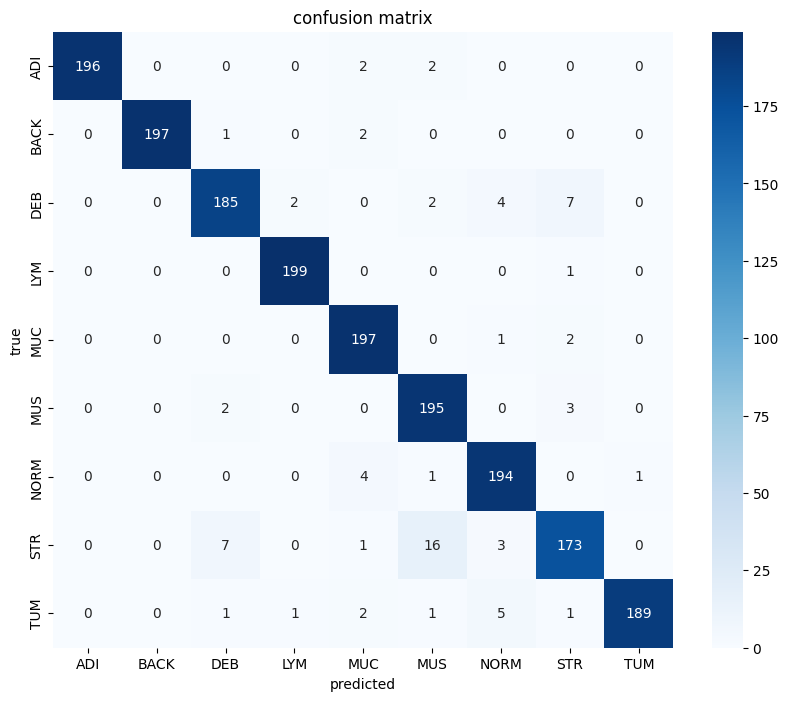

metrics for test_small:
	 accuracy 0.9583:
	 balanced accuracy 0.9583:


In [ ]:
final_model = Model()
final_model.load('best_model')
d_test_tiny = Dataset('test_small')
pred = model.test_on_dataset(d_test_tiny)
Metrics.print_all(d_test_tiny.labels, pred, 'test_small')

Отмонтировать Google Drive.

In [ ]:
drive.flush_and_unmount()